# Validation

In [1]:
import gc
import time
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt
import click
from logzero import logger

In [2]:
%%time
click_data = pd.concat([
    pd.read_feather("../data/basic_table").astype("float"),
    pd.read_feather("../data/click_count_table").astype("float"),
    pd.read_feather("../data/click_time_interval_ip_device_os_app_hash").astype("float"),
    pd.read_feather("../data/intervals_table").astype("float"),
    pd.read_feather("../data/misc_counts").astype("float"),
    pd.read_feather("../data/multi_basic").astype("float"),
    pd.read_feather("../data/next_prev_channels").astype("float"),
    pd.read_feather("../data/ranks_table").astype("float"),
    pd.read_feather("../data/time_of_day").astype("float"),
    pd.read_feather("../data/time_table").astype("float"),
], axis=1)

CPU times: user 1min 51s, sys: 2min 31s, total: 4min 23s
Wall time: 4min 23s


In [3]:
click_data.shape

(203694359, 104)

In [4]:
click_data.dtypes

app                                             float64
channel                                         float64
click_id                                        float64
device                                          float64
ip                                              float64
is_attributed                                   float64
os                                              float64
click_count_by_ip                               float64
click_count_by_ip_os_device_dow                 float64
click_count_by_ip_os_device_dow_hour            float64
click_time_interval_ip_device_os_app_hash       float64
first_click_interval_ip_device_os_app_hash      float64
click_time_interval_by_ip                       float64
click_time_interval_by_ip_os_device             float64
click_time_interval_by_ip_os_device_dow         float64
click_time_interval_by_ip_os_device_dow_hour    float64
first_click_by_ip                               float64
first_click_by_ip_os_device                     

In [5]:
%%time
logger.info("Splitting data...")
click_data.drop(columns=["click_id"], inplace=True)
logger.info("dropped")
train = click_data[click_data["dow"] < 3]
logger.info("created train")
valid = click_data[click_data["dow"] == 3]
logger.info("created valid")

del click_data
gc.collect()

[I 180427 17:30:50 <timed exec>:1] Splitting data...
[I 180427 17:34:32 <timed exec>:3] dropped
[I 180427 17:35:31 <timed exec>:5] created train
[I 180427 17:35:55 <timed exec>:7] created valid


CPU times: user 2min 20s, sys: 2min 45s, total: 5min 5s
Wall time: 5min 5s


In [6]:
%%time
y_train = train["is_attributed"].astype("int")
train.drop(columns=["is_attributed"], inplace=True)

y_valid = valid["is_attributed"].astype("int")
valid.drop(columns=["is_attributed"], inplace=True)
gc.collect()

CPU times: user 29.5 s, sys: 37.1 s, total: 1min 6s
Wall time: 1min 6s


In [7]:
%%time
logger.info("Generating matrix...")
dtrain = xgb.DMatrix(train, y_train)
logger.info("created train")
dvalid = xgb.DMatrix(valid, y_valid)
logger.info("created test")

del train, y_train, valid, y_valid
gc.collect()

[I 180427 17:37:02 <timed exec>:1] Generating matrix...
[I 180427 17:40:42 <timed exec>:3] created train
[I 180427 17:42:11 <timed exec>:5] created test


CPU times: user 3min, sys: 2min 8s, total: 5min 9s
Wall time: 5min 9s


[I 180427 17:42:54 <timed exec>:2] Validating...


[0]	train-auc:0.971114	valid-auc:0.963052
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 25 rounds.
[5]	train-auc:0.980778	valid-auc:0.973834
[10]	train-auc:0.985669	valid-auc:0.977132
[15]	train-auc:0.987535	valid-auc:0.974783
[20]	train-auc:0.985942	valid-auc:0.973107
[25]	train-auc:0.985307	valid-auc:0.970058
[30]	train-auc:0.984906	valid-auc:0.969909
[35]	train-auc:0.985617	valid-auc:0.969312
Stopping. Best iteration:
[12]	train-auc:0.987184	valid-auc:0.977376



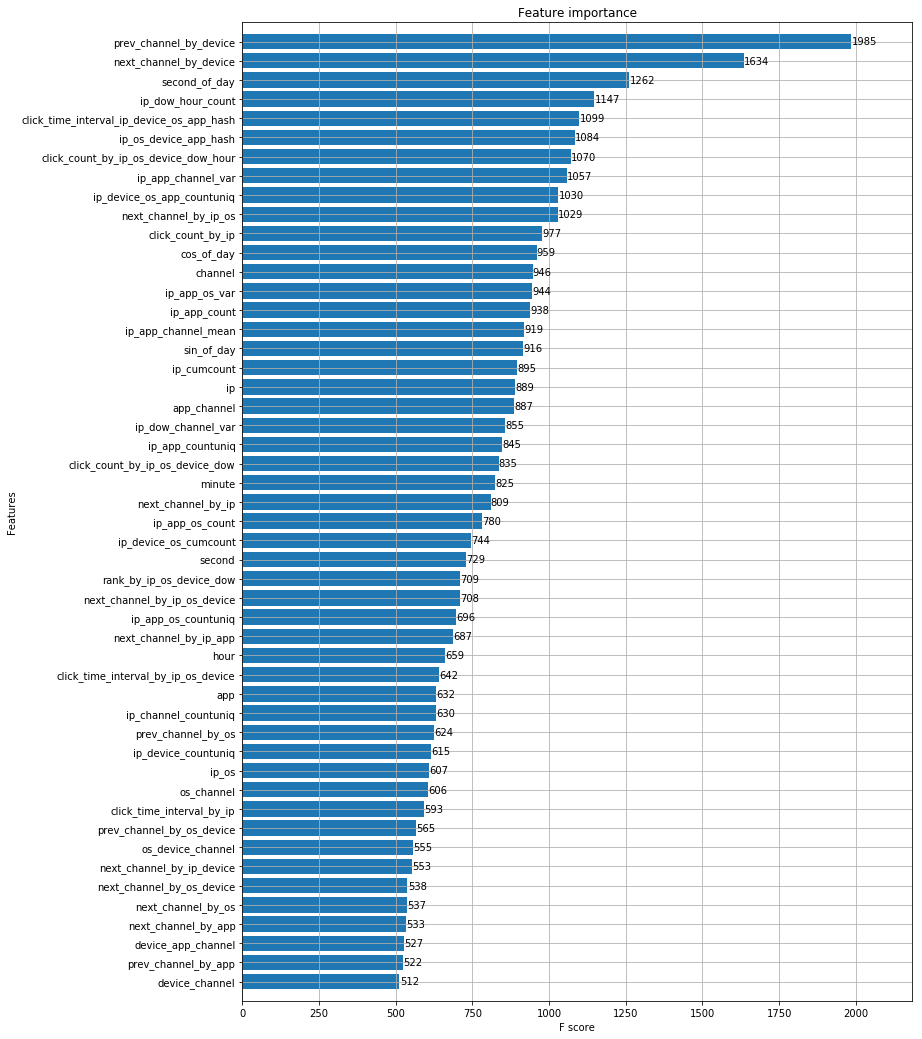

CPU times: user 5h 25min 23s, sys: 2min 57s, total: 5h 28min 21s
Wall time: 40min 43s


In [8]:
%%time
n_thread = 16
logger.info("Validating...")
params = {'eta': 0.6,
          'tree_method': "hist",
          'grow_policy': "lossguide",
          'max_leaves': 1400,
          'max_depth': 0,
          'subsample': 0.9,
          'colsample_bytree': 0.7,
          'colsample_bylevel': 0.7,
          'min_child_weight': 0,
          'alpha': 4,
          'objective': 'binary:logistic',
          'scale_pos_weight': 9,
          'eval_metric': 'auc',
          'nthread': n_thread,
          'random_state': 99,
          'silent': False}
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
model = xgb.train(params,
                  dtrain,
                  200,
                  watchlist,
                  maximize=True,
                  early_stopping_rounds=25,
                  verbose_eval=5)
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

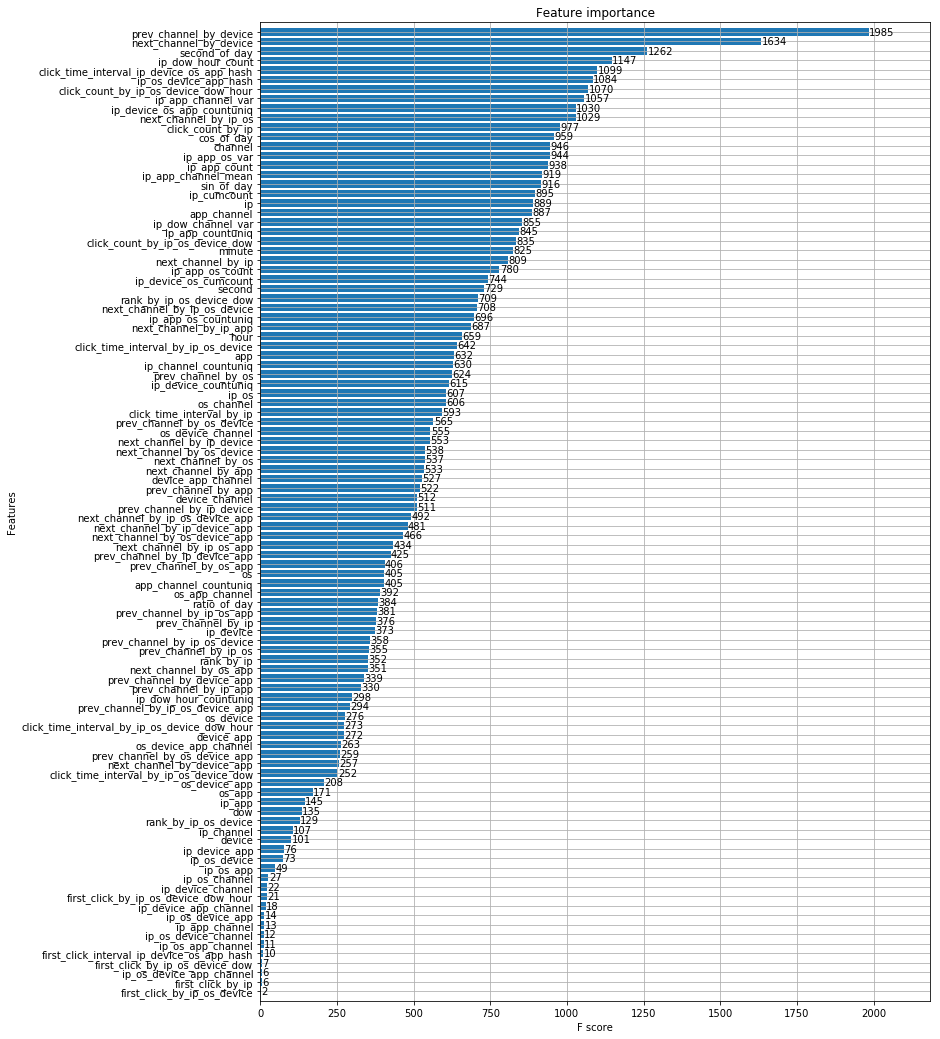

In [9]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=104, height=0.8, ax=ax)
plt.show()

# Prediction

In [1]:
import gc
import time
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt
import click
from logzero import logger

n_thread = 16

In [2]:
%%time
click_data = pd.concat([
    pd.read_feather("../data/basic_table").astype("float32"),
    pd.read_feather("../data/click_count_table").astype("float32"),
    pd.read_feather("../data/click_time_interval_ip_device_os_app_hash").astype("float32"),
    pd.read_feather("../data/intervals_table").astype("float32"),
    pd.read_feather("../data/misc_counts").astype("float32"),
    pd.read_feather("../data/multi_basic").astype("float32"),
    pd.read_feather("../data/next_prev_channels").astype("float32"),
    pd.read_feather("../data/ranks_table").astype("float32"),
    pd.read_feather("../data/time_of_day").astype("float32"),
    pd.read_feather("../data/time_table").astype("float32"),
], axis=1)

CPU times: user 1min 9s, sys: 1min 25s, total: 2min 34s
Wall time: 2min 34s


In [3]:
click_data.shape

(203694359, 104)

In [4]:
click_data.dtypes

app                                             float32
channel                                         float32
click_id                                        float32
device                                          float32
ip                                              float32
is_attributed                                   float32
os                                              float32
click_count_by_ip                               float32
click_count_by_ip_os_device_dow                 float32
click_count_by_ip_os_device_dow_hour            float32
click_time_interval_ip_device_os_app_hash       float32
first_click_interval_ip_device_os_app_hash      float32
click_time_interval_by_ip                       float32
click_time_interval_by_ip_os_device             float32
click_time_interval_by_ip_os_device_dow         float32
click_time_interval_by_ip_os_device_dow_hour    float32
first_click_by_ip                               float32
first_click_by_ip_os_device                     

In [5]:
%%time
logger.info("Splitting data...")
train = click_data[click_data["dow"] != 4]
logger.info("created train")
test = click_data[click_data["dow"] == 4]
logger.info("created test")

del click_data
gc.collect()

[I 180427 20:19:33 <timed exec>:1] Splitting data...
[I 180427 20:21:41 <timed exec>:3] created train
[I 180427 20:21:46 <timed exec>:5] created test


CPU times: user 1min 9s, sys: 1min 4s, total: 2min 14s
Wall time: 2min 14s


In [6]:
%%time
y_train = train["is_attributed"].astype("int")
train.drop(columns=["is_attributed", "click_id"], inplace=True)

test.drop(columns=["is_attributed", "click_id"], inplace=True)
gc.collect()

CPU times: user 17 s, sys: 21.3 s, total: 38.3 s
Wall time: 38.2 s


In [7]:
%%time
feature_names = train.columns
train = train.values
gc.collect()

CPU times: user 84 ms, sys: 0 ns, total: 84 ms
Wall time: 86.3 ms


In [8]:
%%time
logger.info("Generating matrix...")
dtrain = xgb.DMatrix(train, y_train, feature_names=feature_names, nthread=n_thread)
del train, y_train
gc.collect()

[I 180427 20:23:51 <timed exec>:1] Generating matrix...


CPU times: user 2min 34s, sys: 1min 11s, total: 3min 45s
Wall time: 1min 14s


In [9]:
%%time
logger.info("Validating...")
params = {'eta': 0.6,
          'tree_method': "hist",
          'grow_policy': "lossguide",
          'max_leaves': 1400,
          'max_depth': 0,
          'subsample': 0.9,
          'colsample_bytree': 0.7,
          'colsample_bylevel': 0.7,
          'min_child_weight': 0,
          'alpha': 4,
          'objective': 'binary:logistic',
          'scale_pos_weight': 9,
          'eval_metric': 'auc',
          'nthread': n_thread,
          'random_state': 99,
          'silent': False}
watchlist = [(dtrain, 'train')]
model = xgb.train(params, dtrain, 15, watchlist, maximize=True, verbose_eval=1)

[I 180427 20:25:29 <timed exec>:1] Validating...


[0]	train-auc:0.968343
[1]	train-auc:0.97502
[2]	train-auc:0.978429
[3]	train-auc:0.978978
[4]	train-auc:0.979899
[5]	train-auc:0.980295
[6]	train-auc:0.981362
[7]	train-auc:0.981939
[8]	train-auc:0.982623
[9]	train-auc:0.98342
[10]	train-auc:0.984912
[11]	train-auc:0.985488
[12]	train-auc:0.986634
[13]	train-auc:0.986585
[14]	train-auc:0.986646
CPU times: user 3h 28min 10s, sys: 1min 8s, total: 3h 29min 18s
Wall time: 26min 4s


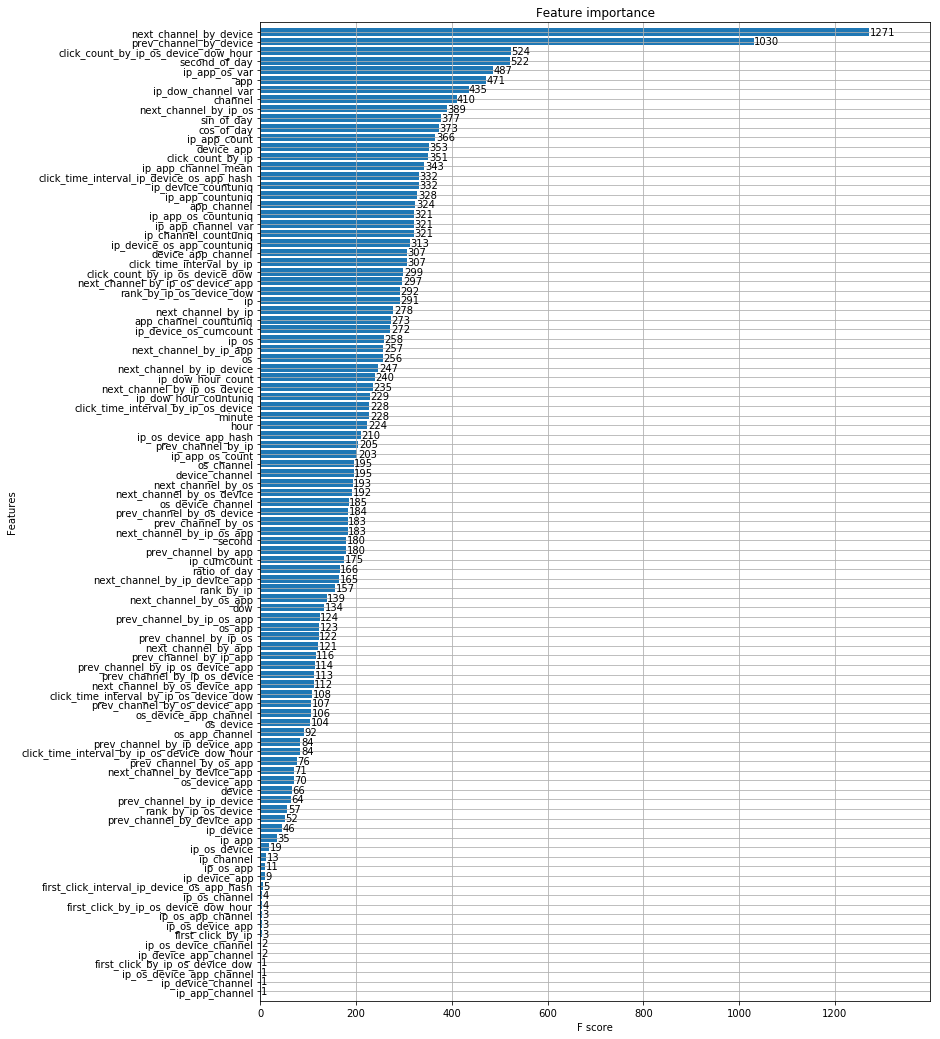

In [10]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=104, height=0.8, ax=ax)
plt.show()

In [ ]:
del dtrain
gc.collect()

In [15]:
%%time
logger.info("Generating test matrix")
test = xgb.DMatrix(test, nthread=n_thread)
gc.collect()

[I 180427 20:52:50 <timed exec>:1] Generating test matrix


CPU times: user 22.6 s, sys: 15.5 s, total: 38.1 s
Wall time: 22.7 s


In [22]:
predicted = pd.concat([
    pd.read_feather("../data/basic_table"),
    pd.read_feather("../data/time_table"),
], axis=1)
predicted = predicted[predicted["dow"] == 4]
predicted = predicted[["click_id"]]

In [23]:
predicted['is_attributed'] = model.predict(test, ntree_limit=model.best_ntree_limit)
predicted.to_csv('xgb_sub.csv',index=False)

In [24]:
sorted([(value, key) for key, value in model.get_fscore().items()], reverse=True)

[(1271, 'next_channel_by_device'),
 (1030, 'prev_channel_by_device'),
 (524, 'click_count_by_ip_os_device_dow_hour'),
 (522, 'second_of_day'),
 (487, 'ip_app_os_var'),
 (471, 'app'),
 (435, 'ip_dow_channel_var'),
 (410, 'channel'),
 (389, 'next_channel_by_ip_os'),
 (377, 'sin_of_day'),
 (373, 'cos_of_day'),
 (366, 'ip_app_count'),
 (353, 'device_app'),
 (351, 'click_count_by_ip'),
 (343, 'ip_app_channel_mean'),
 (332, 'ip_device_countuniq'),
 (332, 'click_time_interval_ip_device_os_app_hash'),
 (328, 'ip_app_countuniq'),
 (324, 'app_channel'),
 (321, 'ip_channel_countuniq'),
 (321, 'ip_app_os_countuniq'),
 (321, 'ip_app_channel_var'),
 (313, 'ip_device_os_app_countuniq'),
 (307, 'device_app_channel'),
 (307, 'click_time_interval_by_ip'),
 (299, 'click_count_by_ip_os_device_dow'),
 (297, 'next_channel_by_ip_os_device_app'),
 (292, 'rank_by_ip_os_device_dow'),
 (291, 'ip'),
 (278, 'next_channel_by_ip'),
 (273, 'app_channel_countuniq'),
 (272, 'ip_device_os_cumcount'),
 (258, 'ip_os'),
 (

# ついでにファイル読み込み高速化の実験

In [1]:
import gc
import time
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt
import click
from logzero import logger

n_thread = 16

In [3]:
%%time
click_data = pd.concat([
    pd.read_feather("../data/basic_table",
                    nthreads=n_thread).astype("float32", copy=False),
    pd.read_feather("../data/click_count_table",
                    nthreads=n_thread).astype("float32", copy=False),
    pd.read_feather("../data/click_time_interval_ip_device_os_app_hash",
                    nthreads=n_thread).astype("float32", copy=False),
    pd.read_feather("../data/intervals_table",
                    nthreads=n_thread).astype("float32", copy=False),
    pd.read_feather("../data/misc_counts",
                    nthreads=n_thread).astype("float32", copy=False),
    pd.read_feather("../data/multi_basic",
                    nthreads=n_thread).astype("float32", copy=False),
    pd.read_feather("../data/next_prev_channels",
                    nthreads=n_thread).astype("float32", copy=False),
    pd.read_feather("../data/ranks_table",
                    nthreads=n_thread).astype("float32", copy=False),
    pd.read_feather("../data/time_of_day",
                    nthreads=n_thread).astype("float32", copy=False),
    pd.read_feather("../data/time_table",
                    nthreads=n_thread).astype("float32", copy=False),
], axis=1, copy=False)

CPU times: user 1min 35s, sys: 1min 53s, total: 3min 29s
Wall time: 2min 49s
